# Table of contents
- [Cleaning](#Cleaning)
- [Analysis](#Analysis)
- [Clustering](#Clustering)
- [Insights](#Insights) 

# Necessary packages

In [65]:
import pandas as pd
#pd set option specified after the loading of the dataset
import seaborn as sns 
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False
#import matplotlib.cm as cm
import matplotlib.colors as colors
#from matplotlib.ticker import PercentFormatter
from datetime import datetime

#for the maps
import folium 
from folium import plugins
from folium.plugins import HeatMap
import geopandas as gpd
from branca.element import Figure
from geopy.geocoders import Nominatim #converts an address into latitude and longitude values 
import osmnx as ox
from shapely.ops import transform
import pyproj
from shapely.geometry import Point, LineString, Polygon
import pyrosm
import contextily as cx
import graphviz

#to work with files
import requests
import json
from pandas.io.json import json_normalize

#for the models 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import graphviz
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import sklearn.metrics
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeRegressor facciamo solo tree che già così può bastare 
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.decomposition import PCA

<a class="anchor" id="Cleaning"></a>

# Cleaning

In [3]:
def clean_starting_dataset(path):
    """
    function that loads the raw data, cleans it and produces 2 dataframes: w/ features object type and one numerical
    directly saving it to the folder 
    """
    #1. LOAD THE RAW DF
    df_raw = pd.read_csv(path)
    columns_to_keep = ['id', 
                       'host_is_superhost', 'host_location','host_about','calculated_host_listings_count',
                       'host_has_profile_pic', 'host_identity_verified',
                       'neighbourhood_cleansed','latitude', 'longitude',
                       'property_type','room_type','accommodates', 'bathrooms_text', 'bedrooms', 'beds', 
                       'amenities', 'price',
                       'minimum_nights','maximum_nights','availability_90',
                       'number_of_reviews','first_review','last_review',
                       'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 
                       'review_scores_checkin','review_scores_communication','review_scores_location', 
                       'review_scores_value', 
                       'license','instant_bookable',
                       'reviews_per_month']
    df1 = df_raw[columns_to_keep]
    
    #2. REMOVE ATTRIBUTES HAVING MISSING>50%
    missing = df1.isnull().sum().to_frame()
    missing.columns = ['missing_abs']
    missing['missing_%'] = round(missing['missing_abs']/(df1.shape[0])*100,2)
    missing.sort_values(by='missing_abs', ascending=False, inplace=True) #fino a qui ottengo numero e % di missing per ttribute
    #qui dico di droppare se è più del 50%
    cols_2manyNA = list(missing[missing['missing_%']>50].index)
    df_noNA = df1.drop(cols_2manyNA, axis='columns')
    
    #3. SEPARATE OBJECT E NUMERICAL DATATYPE
    numerical_attributes = df_noNA.select_dtypes(exclude=['O']).fillna(df_noNA.median()) #directly substitute with the median
    object_attributes = df_noNA.select_dtypes(include=['O'])
    
    #4. CLEAN THE FEATURES
    #4.1 FIX BOOLEAN VALUES (make them actual booleans not strings)
    #identifico le boolean variables
    bool_att = []
    for col in object_attributes.columns.tolist():              #sono stringhe     #queste condizioni per completezza (qui andrebbe a prendere anche True/False)
        if set(df_noNA[col].unique().tolist()) == set(['f','t']) or set(df_noNA[col].unique().tolist()) == set([1,0]) or set(df_noNA[col].unique().tolist()) == set(['1','0']):
            bool_att.append(col)
    #copy to avoid SettingWithCopyWarnings 
    object_attributes = object_attributes.copy()
    #then make each of the bool ctual boolean 
    for col in bool_att:
        object_attributes[col] = object_attributes[col].map(lambda s: False if s == "f" else True) #prima li metto come actual boolean
        object_attributes[col] = object_attributes[col].fillna(object_attributes[col].median())
    
    #4.2 FIX PROPERTY TYPE
    #reduce the levels of the variable 
    categories = ['Apartment','House','Apartment&Services','Hotel','Single_room','B&B','Hostel','Other']
    
    #then group the available categories with the one I define
    object_attributes['property_type'].replace({
        'Condominium': categories[0],
        'Entire condominium': categories[0],
        'Entire apartment': categories[0],
        'Entire loft': categories[0],
        'Loft': categories[0],

        'Villa': categories[1],
        'Townhouse': categories[1],
        'Entire house': categories[1],
        'Vacation home': categories[1],
        'Tiny house': categories[1],

        'Serviced apartment': categories[2],
        'Aparthotel': categories[2],
        'Entire serviced apartment': categories[2],

        'Boutique Hotel': categories[3],

        'Guest suite': categories[4],
        'Private room in apartment': categories[4],
        'Private room in condominium': categories[4],
        'Private room in house': categories[4],

        'Bed and breakfast': categories[5],
        'Private room in bed and breakfast': categories[5],
        'Room in bed and breakfast': categories[5],
        'Guesthouse': categories[5]
        }, inplace=True) 

    #tutti gli altri che non sono tra le categories che io ho definito li metto come other 
    object_attributes.loc[~object_attributes['property_type'].isin(categories), 'property_type'] = 'Other'
    
    
    #4.3 FIX BATHROOMS TEXT
    #estraggo il numero
    object_attributes['bathrooms_text'] = object_attributes['bathrooms_text'].str.extract(r'([0-9.]+)', expand = False)
    #droppo i record che hanno missing bathrooms_text (sono 6 out of più di 3000 quindi ce lo possiamo permettere)
    object_attributes.dropna(axis=0, subset=['bathrooms_text'], inplace=True)
    #sposto bathrooms nel numerical df (e cambio nome da bathrooms_text a bathroom, droppo i missing e lo metto come float no stringa)
    numerical_attributes = numerical_attributes.join(object_attributes['bathrooms_text']) 
    numerical_attributes.rename(columns={'bathrooms_text':'bathrooms'}, inplace=True)
    numerical_attributes.dropna(axis=0, subset=['bathrooms'], inplace=True) 
    numerical_attributes['bathrooms'] = numerical_attributes['bathrooms'].astype(float)
    #e lo droppo dal df di object type 
    object_attributes.drop('bathrooms_text',axis=1, inplace=True)
    
    #4.4 PRICE
    #tolgo currency symbol e -3 per togliere i decimali che sono tutti 0 (non uso round perchè è letto come stringa)
    object_attributes['price'] = object_attributes['price'].str[1:-3] 
    #tolgo la virgola delle migliaia sennò poi non me li converte in integer
    object_attributes['price'] = object_attributes['price'].str.replace(",","")  
    #e converto la feature in integer
    object_attributes['price'] = object_attributes['price'].astype('int64')
    #essendo numerical lo metto nel df numerical e lo droppo da quello object
    numerical_attributes = numerical_attributes.join(object_attributes['price'])
    object_attributes.drop('price', axis=1, inplace=True)
    
    #4.5 HOST ABOUT (kept as the length of the description)
    #no text processing in the interest of time but it would be nice to use as feature the score ofa sentiment analysis 
    #half listings have this values missing but in this perspective it just means a 0 words length description 
    object_attributes['host_about'].fillna("", inplace=True)
    #and then the attribute becomes the number of words used in the description of the host
    object_attributes['host_about'] = object_attributes['host_about'].str.split().str.len()
    #and I move it to the numerical df 
    numerical_attributes = numerical_attributes.join(object_attributes['host_about'])
    object_attributes.drop('host_about', axis=1, inplace=True)

    #4.6 HOST LOCATION (kept aas boolean with 1 if Bologna, 0 otherwise - regardless the specific location)
    #only interested in the impact of staying in the same city of the property 
    #(missing values are very small so get substituted with "Bologna, Emilia-Romagna, Italy", most frequent)
    object_attributes['host_location'].fillna(value="Bologna, Emilia-Romagna, Italy", inplace=True)
    object_attributes['is_hostlocation_Bologna'] = object_attributes['host_location'].map(lambda s: True if s == "Bologna, Emilia-Romagna, Italy" else False)
    object_attributes.drop(['host_location'], axis=1, inplace=True)
    
    #4.7 AMENITIES
    #raggruppo le amenities per un insieme più ristretto 
    #(per evitare di aumentare inutilmente le dimensioni - multicollinearity e curse of dim- e perchè alcune sono proprio rare)
    #e nel farlo faccio direttamente l'encoding delle variabili perchè per ogni amenity aggiungo una boolean feature (ce l'ha vs non ce l'ha)  
    #probabilmente c'è un modo più efficiente, sappimi dire cosa ne pensi 
    lst = list(object_attributes['amenities']) 
    lst_string = " ".join(lst)                 
    lst_string = lst_string.replace("]",",")   
    lst_string = lst_string.replace("[","")
    lst_string = lst_string.replace('"','')  

    amenities = [x.strip() for x in lst_string.split(",")]   
    amenities = set(amenities)  #fino a qui creo la lista delle amenities presenti senza ripetizioni

    #group the amenities aas follows:
    #- technology 5
    object_attributes.loc[object_attributes['amenities'].str.contains('32\\ TV|43\\ HDTV|Cable TV|HDTV|HDTV with premium cable'),'high_end_tv'] = 1
    object_attributes.loc[object_attributes['amenities'].str.contains('TV|TV with standard cable'), 'TV'] = 1
    object_attributes.loc[object_attributes['amenities'].str.contains('Wifi|Wifi \\u2013 10 Mbps|Wifi \\u2013 100 Mbps|Wifi \\u2013 1000 Mbps|Wifi \\u2013 150 Mbps|Pocket wifi|Ethernet connection'),'internet'] = 1
    object_attributes.loc[object_attributes['amenities'].str.contains('Laptop-friendly workspace|Keypad'),'smartworking_tools']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Creative sound system with aux|Game console|Piano|Record player|Sound system|Sound system with Bluetooth and aux|Sound system with aux'),'music_tools']= 1
    #- services from the host to the visitors 9
    object_attributes.loc[object_attributes['amenities'].str.contains('Self check-in|Smart lock'),'autonomous_checkin'] = 1
    object_attributes.loc[object_attributes['amenities'].str.contains('Free carport on premises|Free carport on premises \\u2013 1 space'),'carport']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Free driveway parking on premises \\u2013 1 space|Free parking garage on premises \\u2013 1 space|Free parking on premises|Free parking on premises \\u2013 1 space|Free residential garage on premises \\u2013 1 space|Free street parking'),'free_parking']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Paid parking garage off premises|Paid parking garage on premises|Paid parking lot off premises|Paid parking lot on premises|Paid parking lot on premises \\u2013 1 space|Paid parking lot on premises \\u2013 4 spaces|Paid parking off premises|Paid parking on premises|Paid street parking off premises'),'paid_parking']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Long term stays allowed'),'long_term_stays']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Luggage dropoff allowed'),'luggage_dropoff']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Lock on bedroom door|Lockbox|Window guards|Stair gates'),'security']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Breakfast'),'breakfast_included']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Host greets you'),'host_greetings']=1
    #- kitchen  12
    object_attributes.loc[object_attributes['amenities'].str.contains('Full kitchen|Kitchen'),'kitchen']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Freezer'),'freezer']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Cooking basics|Dishes and silverware'),'eating_basics']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Dishwasher'),'dishwasher']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Microwave'),'microwave']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Refrigerator'),'refrigerator']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('BBQ grill|Barbecue utensils'),'BBQ']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Gas stove|Stove|Stainless steel electric stove|Stainless steel gas stove|Electric stove'),'stove']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Ikea induction stove|Induction stove|Stainless steel induction stove'),'induction_stove'] = 1
    object_attributes.loc[object_attributes['amenities'].str.contains('Bosch stainless steel oven|Candy refrigerator|Indesit refrigerator|Samsung refrigerator|Scavolini stainless steel gas stove|induzione stainless steel induction stove|smeg refrigerator'),'high_end_domesticappliances']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Oven|Stainless steel oven'),'oven']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Coffee maker|Nespresso machine'),'coffee_appliances']=1
    #- bathroom 4
    object_attributes.loc[object_attributes['amenities'].str.contains('BBSHOPPING.IT linea cortesia e accessori per B&B - Linea Check In body soap|BBSHOPPING.IT linea cortesia e accessori per B&B - Linea Check In shampoo|Bathroom essentials|Body soap|Coop body soap|L\'Or\\u00e9al shampoo|Shampoo|Shower gel'),'washing_essentials']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Bathtub|Hot tub'),'bathtub']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Hair dryer'),'hair_dryer']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Washer|Washer \\u2013\\u00a0In building|Washer \\u2013\\u00a0In unit'),'washer']=1
    #- bedroom 1
    object_attributes.loc[object_attributes['amenities'].str.contains('Bed linens|Bedroom comforts|Extra pillows and blankets'),'bed_extras']=1
    #- overall house 16
    object_attributes.loc[object_attributes['amenities'].str.contains('Indoor fireplace'),'indoor_fireplace']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Private entrance|Private living room'),'privacy']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Baby bath|Baby monitor|Babysitter recommendations|Changing table|Children\\u2019s books and toys|Children\\u2019s dinnerware|Crib|Pack \\u2019n Play/travel crib|Table corner guards|High chair|Outlet covers'),'baby_services']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Pets allowed'),'pets_allowed']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Gym'),'gym']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('First aid kit'),'first_aid_kit']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Elevator'),'elevator']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Beachfront|Lake access|Patio or balcony|Garden or backyard|Pool'),'outdoor_spaces']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Fire extinguisher|Fireplace guards|Carbon monoxide alarm|Smoke alarm' ),'fire_precautions']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Single level home'),'single_level_home']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('frigorifero in camera refrigerator|Mini fridge'),'minifridge']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Dryer|Dryer \\u2013\\u00a0In unit'),'dryer']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Iron'),'iron']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Trash compactor'),'trash_compactor']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Air conditioning|Central air conditioning|Conditioner'),'air_conditioning']=1
    object_attributes.loc[object_attributes['amenities'].str.contains('Portable fans|Ceiling fan|Portable air conditioning|Window AC unit'),'other_cooling_tools']=1
    #df.loc[df['amenities'].str.contains('Heating|Central heating|Radiant heating'),'heating']=1 #some sort of heating lo do per scontato

    #quindi droppo la colonna 
    object_attributes.drop(['amenities'],axis=1,inplace=True)

    #definisco lista di quelle finali 
    lst_amen = ['high_end_tv','TV','internet','smartworking_tools','music_tools',

                'autonomous_checkin','carport','free_parking','paid_parking','long_term_stays','luggage_dropoff',
                'security','breakfast_included','host_greetings',

                'kitchen','freezer','eating_basics','dishwasher','microwave','refrigerator','BBQ','stove',
                'induction_stove','high_end_domesticappliances','oven','coffee_appliances',

                'washing_essentials','bathtub','hair_dryer','washer',

                'bed_extras',

                'indoor_fireplace','privacy','baby_services','pets_allowed','gym','first_aid_kit',
                'elevator','outdoor_spaces','fire_precautions','single_level_home',
                'minifridge','dryer','iron','trash_compactor','air_conditioning','other_cooling_tools'
               ]

    #le ho raggruppate e messo 1 se il listing ha quella amenity 
    #ora devo sostituire tutti i None con 0/False 
    #lo faccio iterando sulle possibili amenities
    for amen in lst_amen:
        if object_attributes[amen].isna().sum() > 0:
            object_attributes[amen].fillna(0,inplace=True)  #perchè così ho 1 e 0 
        else:
            pass

    for col in lst_amen:  #final_amen if removing those thaat appear in less than 10% of listings
        object_attributes[col] = object_attributes[col].map(lambda s: True if s == 1.0 else False)
    
    
    #4.8 FIRST REVIEW
    #ci sono circa un 15% di missing values cioè listings che non sono mai stati reviewed 
    #(same n° of missing in first and last review) questi non possono essere eliminati perchè 
    #sono nuovi listings quindi rilevanti per il modello 
    #quindi la strategia è creare una nuova feature che dalla data mi calcola i giorni passati e poi li binno 
    #in  4 categorie, è vero che mi aggiunge altre 5 dimensioni - 4 categorie+"missing" 
    #e lo stesso viene poi fatto con last_review (quindi altre 5) però non mi viene in mente soluzione migliore 
    #per avere una visualizzazione intuitiva 
    
    #quelli che hanno una review li trasformo in datetime 
    object_attributes['first_review'] = pd.to_datetime(object_attributes['first_review'])

    #and then compute the number of days that have passed since the first review
    #and create a new feature with the days passed since the first review 
    today = datetime.today()
    object_attributes['time_since_firstreview']= (today - object_attributes['first_review']).astype('timedelta64[D]')

    def bin_column(df, col, bins, labels, na_label='unavailable'):  #na_label="unavailable"
        """
        Takes in the datafrme, a column name, bin cut points and labels, 
        replaces the original column with a binned version, 
        #and replaces nulls (with 'unavailable' as default).
        """
        df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True) #prende i valori che non sono na e li binna
        df[col] = df[col].astype('str')           #mette in stringa
        df[col] = df[col].replace('nan',na_label) #sostituisce 'nan' con la label data 

    bin_column(object_attributes, 
              'time_since_firstreview',
               bins=[0, 182, 365, 1095, max(object_attributes['time_since_firstreview'])],
               labels=['0-6 months',
                       '6-12 months',
                       '1-3 years', #median here (mean abt 3 years, median 2.5)
                       '3+ years']
              )
    #non droppo "first_review" subito da object attributes perchè lo uso per visualizzare 
    #quanto recenti sono le recensioni
    
    #4.9 LAST REVIEW
    #lo stesso per last review

    #convert to datetime
    object_attributes['last_review'] = pd.to_datetime(object_attributes['last_review'])

    #calculate the number of days between the most recent review and the date today
    object_attributes['time_since_lastreview'] = (today - object_attributes['last_review']).astype('timedelta64[D]')

    bin_column(object_attributes,
               'time_since_lastreview',
               bins=[0, 182, 365, 730, max(object_attributes['time_since_lastreview'])],
               labels=['0-6 months',
                       '6-12 months',
                       '1-2 years',#mean and median almost a year (reasonable given the pandemic)
                       '2+ years']) 
    #FEATURES A POSTO
    #ORA RIFINISCO 
    object_attributes.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True) #lo userò molto quindi faccio nome più breve
    
    #SAVE 
    object_attributes.to_csv('data/object_attributes_fromf.csv', index=False, date_format='%Y-%m-%d')
    numerical_attributes.to_csv('data/numerical_attributes_fromf.csv', index=False)

In [4]:
clean_starting_dataset('data/listings_09.11.20.csv')

C'erano tutte una serie di analisi per arrivare alla definizione di questa funzione ma ho messo solo la funzione finale che lo sistema tutto in una volta

<a class="anchor" id="Analysis"></a>

# Analysis 

In [5]:
#retrieve the df 
obj = pd.read_csv('data/object_attributes_fromf.csv')
num = pd.read_csv('data/numerical_attributes_fromf.csv')

In [6]:
#merge them and save it 
df_clean_notencoded = pd.merge(obj, num, left_index=True, right_index=True)
df_clean_notencoded.to_csv('data/clean_notencoded.csv', index=False, date_format='%Y-%m-%d')

In [7]:
#retrieve and put dates as datetime
df = pd.read_csv('data/clean_notencoded.csv')
df['last_review'] = pd.to_datetime(df['last_review'])
df['first_review'] = pd.to_datetime(df['first_review'])

## Most common property and room type

<ipython-input-8-3ec750f09e7c>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


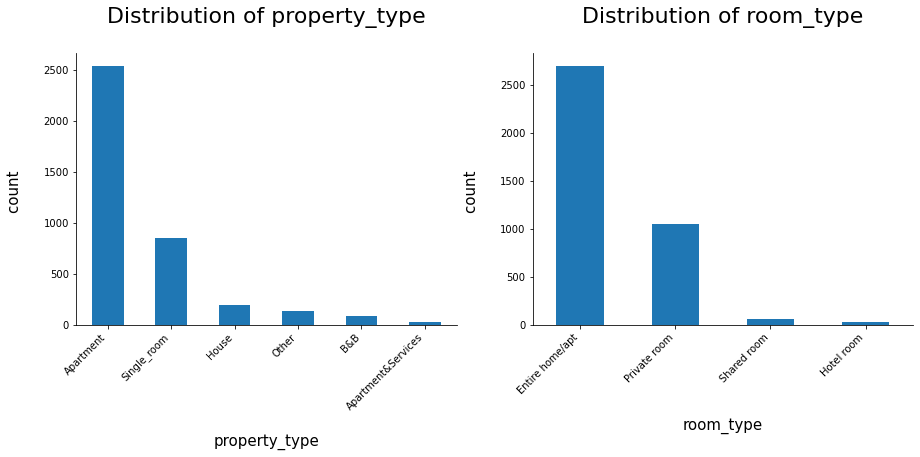

In [8]:
#WHAT ARE THE MOST COMMON PROPERTY AN ROOM TYPE
def category_count_plot(df, col, figsize=(20,10)):
    """
    plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.ylabel('count', fontsize=15)
    plt.xlabel(col, fontsize=15)
    plt.title(col, size=20, fontweight="bold")
    plt.xticks(rotation=45,horizontalalignment="right" )
    plt.style.use("seaborn-talk")
    sns.despine()
    plt.show()

    
features = ['property_type', 'room_type']

fig, ax = plt.subplots(1, len(features),figsize=(15,5))
for i, features in enumerate(df[features]):
    df[features].value_counts().plot(kind="bar", ax=ax[i]).set_title('Distribution of '+features +'\n', fontsize=22)
    ax[i].set_ylabel('count \n', fontsize=15)
    ax[i].set_xlabel('\n'+features, fontsize=15)
    ax[i].set_xticklabels(labels= df[features].unique(),rotation=45,horizontalalignment="right" )
sns.despine()
fig.show()

So we can see that:
- the offer of properties in Bologna consists mainly of several types of apartments about 65% (remember from the cleaning that "apartment" includes: condominium, entire condominium, entire apartment, entire loft and lof) 
- followed by the offer of single rooms about 25% and loosely by houses.  
- Aparthotel, B&Bs and other options are the least common offer. 

As for the room type:
- one can easily find entire apartments or homes (meaning that the booking implies that the traveller will be alone in the whole property). This option makes up the greatest part of the offer, 
- then a relatively significant portion of the market is composed of private rooms signaling that privacy is a great added value when booking properties on Airbnb. 
- (The least common offer in terms of room_type is the shared room and hotel room - this because this type of hospitality typically uses other platforms such as Booking).

## Most common setup

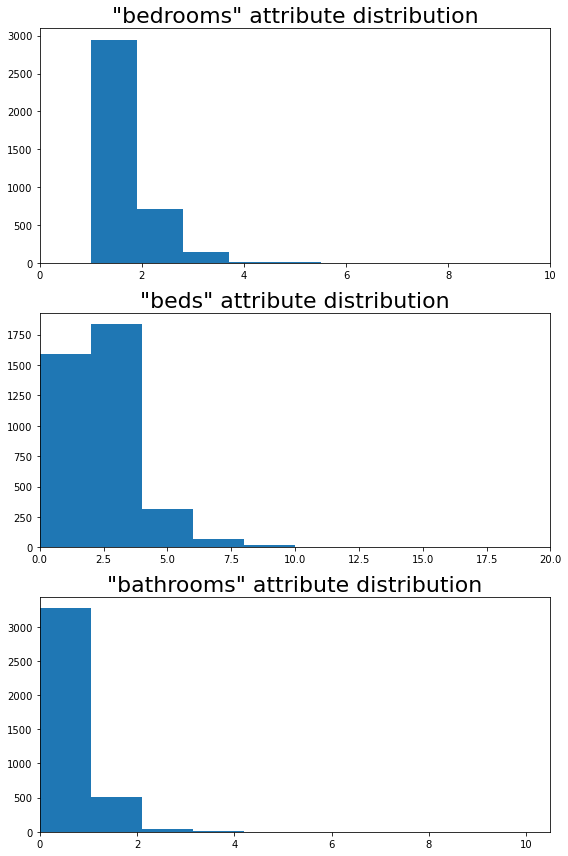

<Figure size 432x288 with 0 Axes>

In [9]:
#WHAT IS THE MOST COMMON SETUP
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(8,12))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title('"'+var_name+'"'+ ' attribute distribution', fontsize=22)
        ax.set_xlim(0,max(df[var_name]))
        ax.grid(False)
    fig.tight_layout()  
    plt.show() 
    plt.figure()
    
draw_histograms(df,['bedrooms','beds','bathrooms'],3,1);

The most common set-up is to offer 1 bedroom, with 2 beds and at least 1 bathroom. (Memo: improve visualization)

## Reviews

Ok, so far we have the most common offer and as a potential host my possible strategies are either: 
- a) cost focus -> seeking cost advantage (offer a product similar to that being offered but adjust the price to be more competitive - though price and cost are not the same, you get the bottom line)
- b) product differentiation ->  change your proposal in order to answer special needs of buyers  

to understand which option is preferable the host needs to understand if the customers are currently satisfied with the offer so first we look at the reviews to have a feeling of the customers's satisfaction

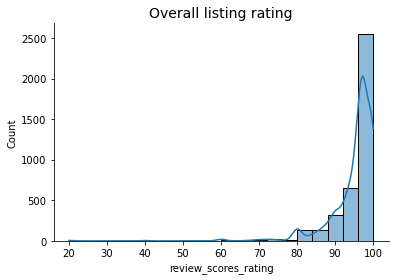

In [10]:
# overall listing rating -> this in histplot because it goes up to 100
sns.histplot(df['review_scores_rating'], kde=True, bins=20)
sns.despine()
plt.title('Overall listing rating', fontsize=14)
plt.show()

- Ratings for the listings in Bologna are generally rather high (>91, most frequent rating is 97 followed by 100 then the first most frequent 10 values are >90). 
- When not in this excellent portion, listings tend to be around 80 so good but not excellent. 
- Very few listings have less than 60 but if less than 60 then goes directly down to 20. 
- overall customers seem to be satisfied with the offer meaning that when booking a property in Bologna they actually want mainly a room in an apartment with 2 beds and one bathroom so I would advise a potential host not to change this formula

Yet, this overall evaluation is broken down into 6 dimensions so as a potential host I might be interested in understanding whether there is a particular aspect that current hosts are not answering/partially answering (as I could start by tackling that aspect first in order to attract costumers )

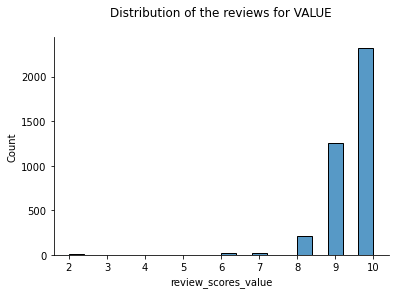

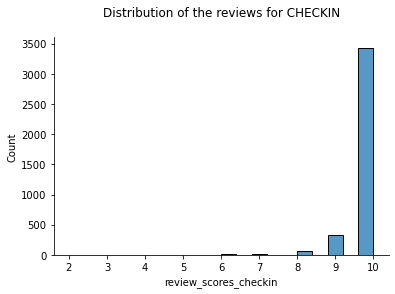

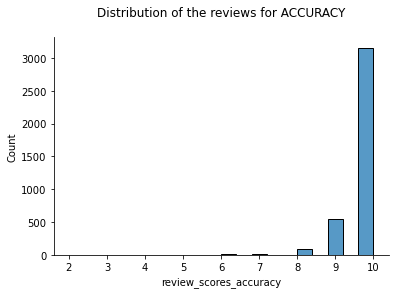

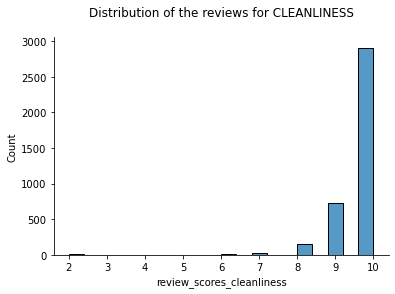

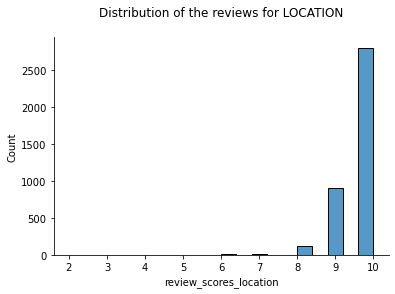

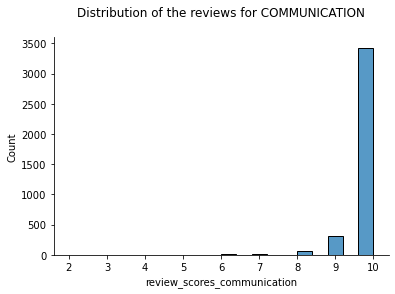

<Figure size 432x288 with 0 Axes>

In [42]:
#this is the overall rating, let's see how is broken down for each aspect of the evaluation
#(loc)
fig, ax = plt.subplots()
#plt.title('Analysis of the rating - broken down per dimension \n', fontsize=22 )
for col in dim_of_eval:
    sns.histplot(df[col], bins=20)
    sns.despine()
    plt.title("Distribution of the reviews for "+ col.rsplit('_', 1)[-1].upper() +'\n')
    plt.show()
    plt.figure()

- Ratings tend to be high in all dimensions 
- There is not dimension on which a new host could focus to better answer customers' needs 
- if a suggestion is to be given, then since accuracy e cleanliness sono quelle in cui ci sono più giudizi negativi as a potential host I would make sure to offer a clean environment and that customers' have realistic expectations of the property. 

We are grounding the choice for the strategy on the reviews but are these actually reflecting the current situation? Because we could be talking about years old reviews so we check how many of the listings have had their last review in the last 6 months (count the number of listings for category of time passed since the last review)

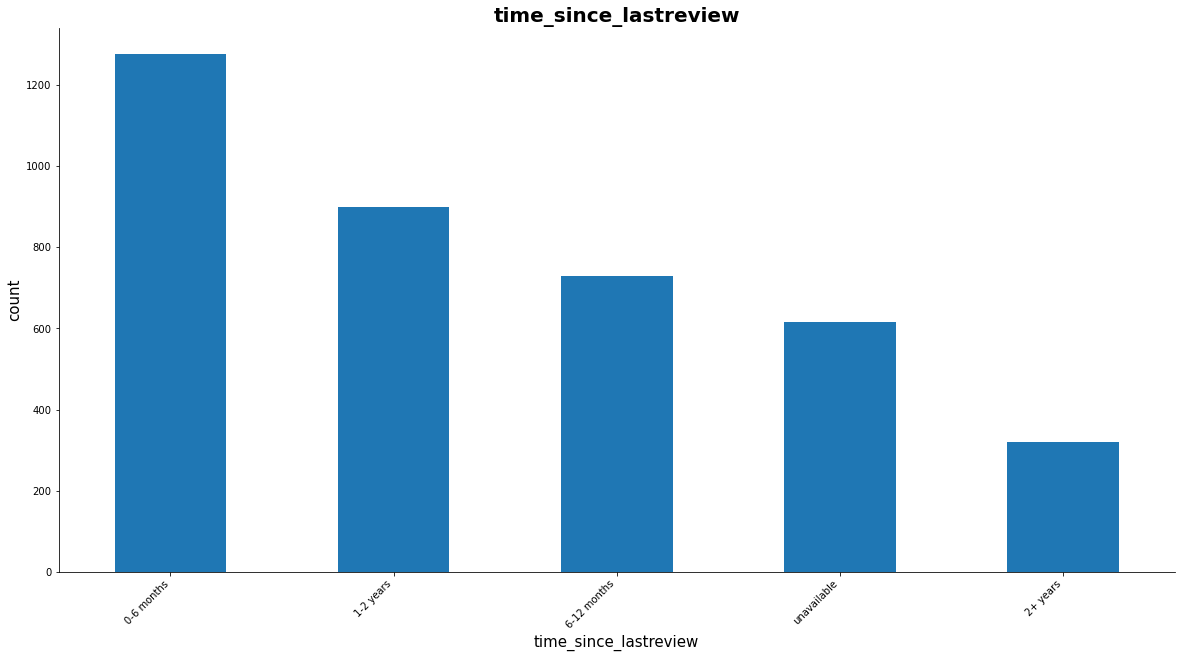

In [43]:
 category_count_plot(df, 'time_since_lastreview')

Most of the listings have had their last review in the last 6 months so I know I can relatively trust the picture given by the reviews and should assume customers are relatively satisfied with the offer (clearly, analyzing the reviews only gives us the opinion of the current customers, the demand of potential customers is left untapped - meaning I could choose to differentiate my offer and still be successfull because I am attracting customers that have never booked with Airbnb before but still we assume we can relatively generalize to entire demand) (also it gives us a feeling of the current engagement with the platform)

So from here we understand that changing the current setup (which is mainly for one or two people) is not advisable for a potential host, non c'è evidenza per avviare una strategia di differenziazione (differenziazione di property e setup) ma piuttosto focalizzarsi sul prezzo

## Price analysis 
So the current setup seems to work with the customers and as a potential host I should focus on the price. The cost seems to be a better action lever (wrt differentiate the offer) so let's look at the current offer in terms of prices.

### overall distribution

In [44]:
# What is the overall distribution of prices?
print(f"Nightly advertised prices range from €{min(df.price)} to €{max(df.price)}.")

Nightly advertised prices range from €9 to €3000.


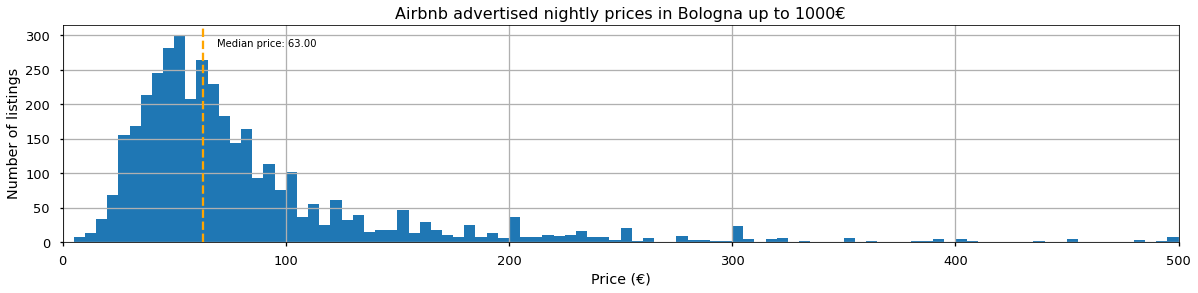

In [45]:
# Distribution of prices from 0 to 500€ - (would go up to 3000€) 
# FOCUS ON THE LEFT BECAUSE THAT'S WHERE MOST OF THE PROPERTIES ARE
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,500)) #used max(df['price']) so 3000 but most listings are way below
plt.margins(x=0)
plt.title("Airbnb advertised nightly prices in Bologna up to 1000€", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.axvline(df['price'].median(), color='orange', linestyle='--') #most listings have a price below 
min_ylim, max_ylim = plt.ylim()
plt.text(df['price'].median()*1.1, max_ylim*0.9, 'Median price: {:.2f}'.format(df['price'].median()))
plt.show()
#heavy tailed prices (to keep in mind when predicting)

- the nightly price for properties on airbnb in Bologna ranges from just 9€ to 3000€. 
- most properties ask for a nightly price lower than 63€ 
- the price feature is tail heavy (extends to much farther to the right of the median) - as lons as we are here in the analysis is fine to keep all listings but before the models for the price prediction I'll set a cutoff point and maybe log transform to have a more normal distribution (in order to have the aassumptions of the linear model respected) 

### Trend in time
Ok this is the current picture but how have prices changed over time? We take as reference the year of the first review and plot the boxplot of the prices per each year


C:\Users\isada\Anaconda3\envs\geo_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


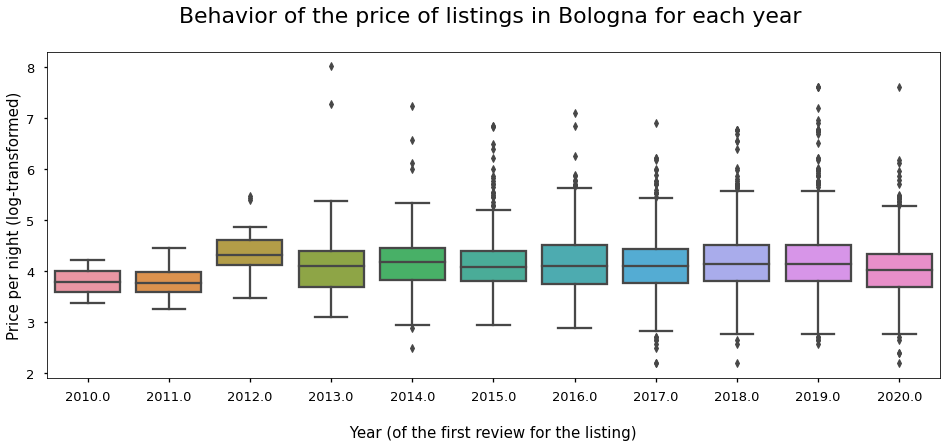

In [66]:
plt.figure(figsize=(16,6))
x = df['first_review'].dt.year
y = np.log(df['price'])#log transformation of the price to make them comparable 
                       #and not shrunken to the bottom prices 
sns.boxplot(x,y)  
plt.xlabel('\n Year (of the first review for the listing) ', fontsize=15)
plt.ylabel('Price per night (log-transformed)', fontsize=15)
plt.title('Behavior of the price of listings in Bologna for each year \n', fontsize=22)
plt.show()

To a potential host I would say that there is no striking trend to be spotted in the price variation thorugout the years but if we keep into account small variations then: 
- throughout the years there has been an increase in price variability and only a slight increase in mean price (in 2020 price is higher than 2010) with a peak in 2012
- however in the last year one can notice that the mean price has decreased but this is clearly something one should expect given the circumstances

### Relationship price and reviews
Here the price gets analyzed by plotting the scatterplot of price and reviews to understand the relationship.

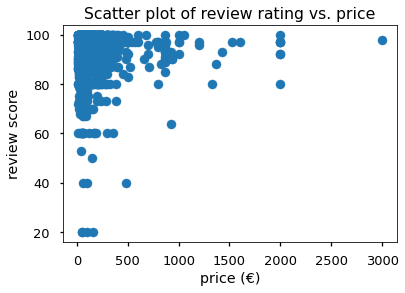

In [67]:
# REVIEWS AND PRICE 
#scatterplot price e review 
plt.scatter(df['price'],df['review_scores_rating'])
plt.xlabel('price (€)')
plt.ylabel('review score')
plt.title('Scatter plot of review rating vs. price')
plt.show()

There is only one property for which, regardless the extremely high price, the review score is maximum. Despite some extremely cheap listings that made customers complain (20 review), the overall trend seems to be that the lower the price the more satisfied the customers.

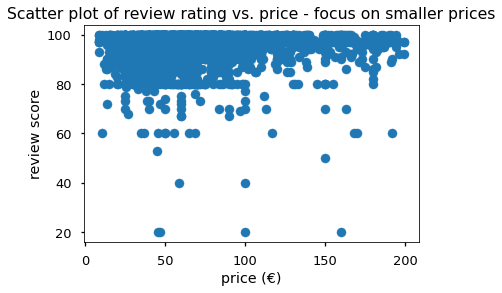

In [68]:
# FOCUS ON SMALLER PRICES
data = df[df['price'] < 200]
plt.scatter(data['price'],data['review_scores_rating'])
plt.xlabel('price (€)')
plt.ylabel('review score')
plt.title('Scatter plot of review rating vs. price - focus on smaller prices')
plt.show()

If we assume the reviews to represent the demand (we don't have data about the actual bookings - ie. the current demand - so we use reviews as a proxy) one could conclude that there is low elasticity in the demand because up to about 125 euros reviews are consistently high (clearly there are some limits: a) reviews only measure "current" demand b) properties being offered on the platform are generally cheaper so not all price ranges are represented equally). 

Bottom line for a potential host: customers are relatively indifferent to higher prices up to a roof of about 100€

### Median price charged per number of people hosted (memo: decide if keeping it or not)

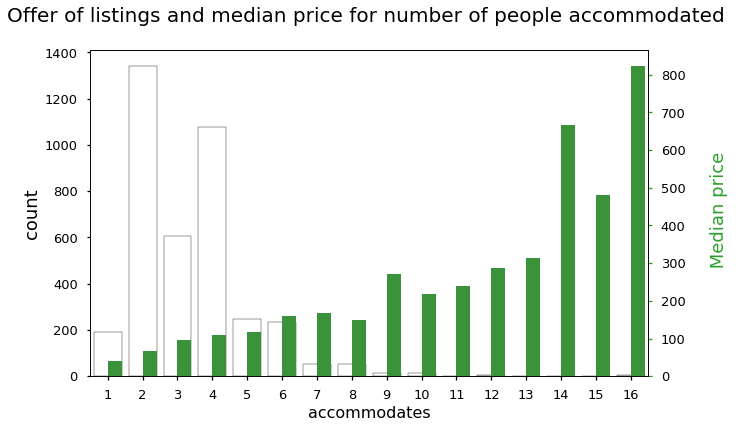

In [48]:
#Number of listings (=offer) per people accomodated compared to price 
df.loc[:,'dummy'] = 'dummy' #this is needed just to have the bars not overlapping 
#matplotlib does this automatically but seaborn is better looking 

#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))

color = '#000000' #black
#bar plot creation
ax1.set_title('Offer of listings and median price for number of people accommodated \n', fontsize=20)
ax1.set_xlabel('accommodates', fontsize=16)
ax1.set_ylabel('count', fontsize=18, color= color)
ax1 = sns.countplot(data=df,x='accommodates', fill= False) 
ax1.tick_params(axis='y')

#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:green'
#line plot creation
ax2 = sns.barplot(x='accommodates',y='price',data=df,hue='dummy', color = 'tab:green', ci=None, hue_order=['other','dummy'])
ax2.set_ylabel('\n Median price', fontsize=18, color=color)
ax2.tick_params(axis='y', color=color)

ax2.legend_.remove()

#show plot
plt.show()

df.drop(['dummy'],axis=1, inplace=True)

Reasonably, the price is higher for properties that accomodate a greater number of people but the return stops to grow linearly after about 7 people accomodated. This means that the relationship between the median price charged and the number of people the property can accomodate is linear only up to about 7 people, then the behavior is less predictable. In fact, for one additional person accomodated there is no increase from 7 to 8 people but then one additional person from 8 to 9 significantly increase the price but then again from 9 to 10 the price decrease. Since the returns do not justify having properties that accomodate a great number of people it's advisable for a potential host to remain below 4 people accomodated even though that's where most of the market is offering (and so the competition is fiercer). 

- Bottom line: there is not a linear relationship between people hosted and median price and most offer is focused on hosting less people - you charge less as nightly price but represent a more steadly income

## Which area of Bologna has the most properties?
Since the competiton will be fiercer as a host I might be interested in focusing on areas that have less properties. So here the density of properties being offered is analyzed (using Folium) as follows:
1. first all listings available are plotted
2. then the heatmap because it helps us better understanding the areas where there are more listings
3. the heatmap gives us an overall view but we want the actual name of the neighbourhood (because those will be used to filter)
4. so then we plot a cloropleth map first for the count of listings per neighbourhood then for the median price to assess which areas are the most expensive

Here I connect the geojson of the data to create the dataframe with the geometries (map_df)

In [69]:
# import the GeoJSON file as a dataframe in geopandas (that from insideAirbnb)
map_df = gpd.read_file('data/neighbourhoods_09.11.20.geojson') #gives me the geometries of the neighbourhoods
# We don't need neighbourhood_group so it gets dropped
map_df.drop('neighbourhood_group', axis=1, inplace=True)

To give some context:
- Borgo Panigale - Reno: close to the airport
- Navile: Bologna Fiere traa Naavile e San Donato/San Vitale 
- Porto Saragozza: on thee way from the airport to the city centre
- San Donato - San Vitale: residential area (POI: FICO Eataly)
- Santo Stefano: centro storico
- Savena: colline e Sant'Orsola (ospedale)

### all listings

In [70]:
#here I retrieve the latitude and longitude for the centroids
address = 'Bologna, Emilia Romagna, Italy'

geolocator = Nominatim(user_agent="isabella.dario@studenti.unit.it") #https://wiki.openstreetmap.org/wiki/Nominatim#Parameters
location = geolocator.geocode(address)                               #if it says user rate exceeded just change user agent (put your email or another email)

latitude = location.latitude     #these are used in all the following maps
longitude = location.longitude

print('The coordinates of Bologna are {}, {}.'.format(latitude, longitude))

The coordinates of Bologna are 44.4937577, 11.3430308.


In [71]:
# here I create a map with all listings in Bologna present on Airbnb 
#using latitude and longitude values of the df
map_Bolo = folium.Map(location=[latitude, longitude], zoom_start=12)  

# add markers to map
for lat, lng, neighbourhood, room_type, rating in zip(df['latitude'], 
                                                      df['longitude'], 
                                                      df['neighbourhood'], 
                                                      df['room_type'], 
                                                      df['review_scores_rating']):
    label = '{}, {}, rating: {}'.format(neighbourhood, room_type, rating)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Bolo)

map_Bolo

### Heatmap to better grasp densities

In [72]:
# Heatmap of number of listings in Bologna 
#to see the density of properties across different areas 
m = folium.Map(location=[latitude,longitude],zoom_start=12)

heat_data = [[row['latitude'],row['longitude']] for index,row in df[['latitude','longitude']].iterrows()]

hh = HeatMap(heat_data).add_to(m)

m

l'heatmap che mi da birdeye view ma mi interessa avere proprio la divisione in quartieri perchè sono quelli che poi nel sito vengono usati per filtrare quindi prima vedo "which area has the most properties?" poi "which area is the most expensive?"

### Interactive Cloropleth for count and median price (remove the non interactive) 
Here with Folium library I plot the map with the count of listings per neighbourhood and the median price (it gets displayed with the tooltip)

In [73]:
# we need to extract the count of listings from the df 
neigh_df = pd.DataFrame(df.groupby('neighbourhood').size())                    #how many listings per neighbourhood
neigh_df.rename(columns={0: 'number_of_listings'}, inplace=True)

#and add the median price per neighbourhood
neigh_df['median_price'] = df.groupby('neighbourhood').price.median().values   #median price per neighbourhood

# eventually join this df with that with the geometries (map_df)
neigh_map_df = map_df.set_index('neighbourhood').join(neigh_df)  #set the index to join it properly

#### count

In [74]:
neigh_map_df['neighbourhood'] = neigh_map_df.index #need to have it as a column for these more interactive viz

# Create basemap
fig5 = Figure(width = 800, height = 800)
m5 = folium.Map(location = [latitude,longitude],zoom_start = 12) #forse con tiles = 'cartodbpositron' meglio (prova e dimmi) 

folium.GeoJson(
    neigh_map_df,
    style_function=lambda feature: {
        #'fillColor': 'white',
        'color': 'black',
        'weight': 0.5
    }
    ).add_to(m5)

fig5.add_child(m5)

# Generate choropleth map 
folium.Choropleth(
    geo_data = neigh_map_df.to_json(),
    data = neigh_map_df,
    columns=['neighbourhood', 'number_of_listings'],
    key_on = 'feature.properties.neighbourhood',
    fill_color = 'Reds', 
    legend_name = "Number of listings on Airbnb").add_to(m5)

# Add tooltips
folium.features.GeoJson(data = neigh_map_df,
                        name = 'Labels',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        tooltip = folium.features.GeoJsonTooltip(
                                fields= ["neighbourhood", "number_of_listings"],
                                aliases = ["neighbourhood", "count"],
                                labels=True,
                                sticky=False
                                                                            )
                        ).add_to(m5)
# Add title
title_html = '''
            <h3 align="center" style="font-size:20px"><b>Count of properties by neighbourhood in Bologna</b></h3>
             '''
m5.get_root().html.add_child(folium.Element(title_html))

m5

#with the tooltip if you put the cursor on the map you'll see the name of each neighbourhood and the corresponding value

In [75]:
# Top 3 neighbourhoods where the are more properties being advertised on Airbnb
neigh_map_df.sort_values(by='number_of_listings', ascending=False).head(3)

geometry  \
neighbourhood                                                                
Santo Stefano            MULTIPOLYGON (((11.35710 44.49376, 11.35730 44...   
Porto - Saragozza        MULTIPOLYGON (((11.31848 44.51106, 11.31870 44...   
San Donato - San Vitale  MULTIPOLYGON (((11.39932 44.54174, 11.39876 44...   

                         number_of_listings  median_price  \
neighbourhood                                               
Santo Stefano                          1381            69   
Porto - Saragozza                      1275            65   
San Donato - San Vitale                 487            55   

                                   neighbourhood  
neighbourhood                                     
Santo Stefano                      Santo Stefano  
Porto - Saragozza              Porto - Saragozza  
San Donato - San Vitale  San Donato - San Vitale

- the area that has the most properties advertised in Airbnb is Santo Stefano followed by Porto Saragozza
- less popular areas are Naville, San Donato/San Vitale
- least popular Borgo Panigale/Reno e Savena 

#### median price

In [76]:
# Create basemap
fig3 = Figure(width = 800, height = 800)
m3 = folium.Map(location = [latitude,longitude], zoom_start = 12) #tiles = 'cartodbpositron'

folium.GeoJson(
    neigh_map_df,
    style_function=lambda feature: {
        #'fillColor': 'white',
        'color': 'black',
        'weight': 0.5
    }
    ).add_to(m3)

fig3.add_child(m3)

# Generate choropleth map 
folium.Choropleth(
    geo_data = neigh_map_df.to_json(),
    data = neigh_map_df,
    columns=['neighbourhood', 'median_price'],
    key_on = 'feature.properties.neighbourhood',
    fill_color = 'Reds', 
    legend_name = "Median nightly price").add_to(m3)

# Add tooltips
folium.features.GeoJson(data = neigh_map_df,
                        name = 'Labels',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        tooltip = folium.features.GeoJsonTooltip(
                                fields= ["neighbourhood", "median_price"],
                                aliases = ["neighbourhood", "nightly price (€)"],
                                labels=True,
                                sticky=False
                                                                            )
                        ).add_to(m3)
# Add title
title_html = '''
            <h3 align="center" style="font-size:20px"><b>Median nightly price of listings in Bologna by neighbourhood</b></h3>
             '''
m3.get_root().html.add_child(folium.Element(title_html))

m3

C:\Users\isada\Anaconda3\envs\geo_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


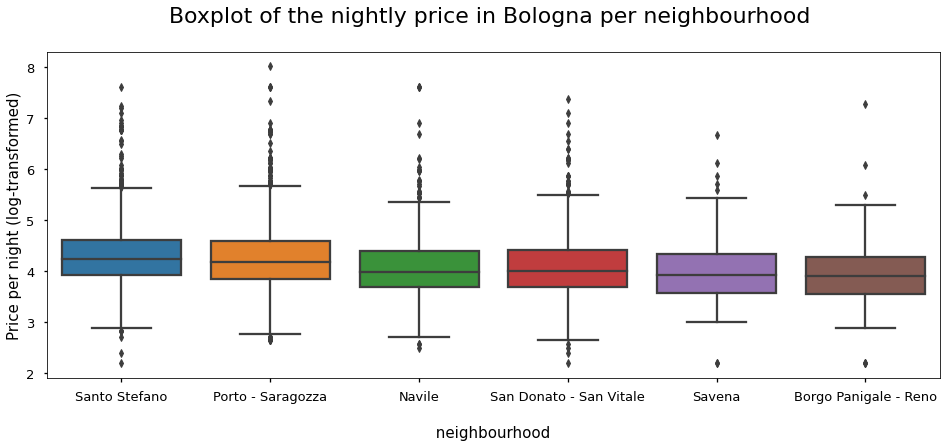

In [77]:
#boxplot of the (log transformed) prices per neighbourhood
plt.figure(figsize=(16,6))
x = df['neighbourhood']
y = np.log(df['price'])
sns.boxplot(x,y)  
plt.xlabel('\n neighbourhood ', fontsize=15)
plt.ylabel('Price per night (log-transformed)', fontsize=15)
plt.title('Boxplot of the nightly price in Bologna per neighbourhood \n', fontsize=22)
plt.show()

In [78]:
# Top 3 neighbourhoods where the price is the highest
neigh_map_df.sort_values(by='median_price', ascending=False).head(3)

geometry  \
neighbourhood                                                                
Santo Stefano            MULTIPOLYGON (((11.35710 44.49376, 11.35730 44...   
Porto - Saragozza        MULTIPOLYGON (((11.31848 44.51106, 11.31870 44...   
San Donato - San Vitale  MULTIPOLYGON (((11.39932 44.54174, 11.39876 44...   

                         number_of_listings  median_price  \
neighbourhood                                               
Santo Stefano                          1381            69   
Porto - Saragozza                      1275            65   
San Donato - San Vitale                 487            55   

                                   neighbourhood  
neighbourhood                                     
Santo Stefano                      Santo Stefano  
Porto - Saragozza              Porto - Saragozza  
San Donato - San Vitale  San Donato - San Vitale

- prices don't vary significantly, these above are the top 3 but overall the prices are relatively similar
- Santo Stefano is historical center so despite the great offer of properties, it has the highest prices
- followed by Porto-Saragozza probably due to the fact that it's in between the airport and the city centre
- then San Donato - San Vitale and Navile probably because in the former there is the hospital (Sant'Orsola) and in the latter BolognaFiere (anche tipo FICO Eataly è in quelle zone)

Questi risultati dell'analisi vengono direttamente outputtati 

<a class="anchor" id="Clustering"></a>

# Clustering 
Qui procedo a fare il clustering dei vari listings e per farlo devo:
1. recuperarmi i dataset
2. creare dummy variables per le variabili categoriche (e rimuovere first e last review che uso solo nelle viz) 
3. applicare l'algoritmo di dimensionality reduction (alternativa è tsne ma è abbastanza intensive) 
(we need to apply the algorithm for 2 reasons: 

(a) [more critical] the dataframe originally contains both datatype, even with categorical variables encoded the df could not be fed to a clustering algorithm like KMeans because it uses Euclidean distance as pairwise distance (which does not make sense for categorical variables) so first PCA then feed scores to clustering.   
(b) [less critical because about a 100 features] there are may features so we use PCA to combine the original attributes in leaner versions of them so that we can focus on the most important ones (in the first components we aree combining the most important features)
)

4. unisco gli score con il df (dopo aver recuperato neighbourhood not encoded e creato nuova feature per il budget)
5. applico l'algoritmo di clustering sugli score della PCA (KMeans)
6. output sulla mappa

In [79]:
#1. RETRIEVE DATASETS

#retrieve object types 
obj = pd.read_csv('data/object_attributes.csv')
print(f'Object type df has {obj.shape[1]} attributes')

#retrieve numerical
num = pd.read_csv('data/numerical_att.csv')
print(f'Numerical type df {num.shape[1]} attributes')

Object type df has 59 attributes
Numerical type df 22 attributes


In [80]:
#2. FIX AND ENCODE VAR AND SAVE THE DF CLEAN AND ENCODED 

#remove first e last review 
#che usavamo solo nella prima sezione di analisi (non entrano nei modelli)
obj.drop(['first_review','last_review'], axis=1, inplace=True)

#encode categorical variables 
encoded = pd.get_dummies(obj)

#merge the two
df_cleaned_encoded = pd.merge(num, encoded, left_index=True, right_index=True)

#save the clean encoded to csv --> USATO PER CLUSTERING 
df_cleaned_encoded.to_csv('data/clean_encoded.csv', index=False) 

In [83]:
#3. APPLY PCA (get PCA scores)

#retrieve dataset
df_pca = pd.read_csv('data/clean_encoded.csv') 

#first we need to scale (otherwise it does not make sense to compare the variance associated to each feature )
X = df_pca.drop(['id'], axis=1) #all attributes minus the id
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

#then need to choose the n° of components(n° of eigenvalues of the eigenvalues matrix generated by SVD)
#visually we can plot the cumulative explained variance and select the x where the explained variance is 95
pca = PCA().fit(X)
#conta che a volte mi è uscito SVD did not converge ma in realtà non era legato ai dati bensì alla memoria 
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance')

#non lo posso fare visually ma devo dirgli come ottenere il n° di components con il codice e io chiedo
#che prenda un n° di components necessari a spiegare almeno il 95% della varianza 
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

n_comp = np.where(np.asarray(cum_explained_var)> 0.95)[0][0]   #cum_explained_var[-1] per sapere il valore preciso

#quindi poi fitto
pca = PCA(n_components = n_comp)
model = pca.fit(X)

#to visualize how much variance is explained by each component
#features = range(pca.n_components_)
#plt.figure(figsize=(18,10))
#plt.bar(features, pca.explained_variance_)
#plt.xticks(features)
#plt.ylabel('variance')
#plt.xlabel('PCA feature')
#plt.show()

pca_features = pca.transform(X)
pca_df = pd.DataFrame(pca_features) #here we have all the scores of the PCA, eventually join to the original df for clustering

pca_df.to_csv('data/pca_scores.csv', index=False)

In [84]:
#4. CREO DF PER CLUSTERING
#4.1 Per la visualizzazione mi servirà il neighbourhood non encoded quindi lo recupero 
notencoded = pd.read_csv('data/clean_notencoded.csv') 

#4.2 ci aggiungo una feature che esprime il budget (bin del price 4 easier viz)
#boxplot = notencoded.boxplot(column='price')
#print(f"Low-medium threshold: {notencoded['price'].quantile(q=0.30)}")
#print(f"Medium-high threshold: {notencoded['price'].quantile(q=0.80)}")

low_indexes = notencoded[notencoded.price < 50].index
med_indexes = notencoded[(notencoded.price >= 50) &
                         (notencoded.price < 200)].index
high_indexes = notencoded[(notencoded.price >= 200)].index

notencoded.loc[low_indexes, 'budget'] = 'low'
notencoded.loc[med_indexes, 'budget'] = 'medium'
notencoded.loc[high_indexes, 'budget'] = 'high'

#4.3 quindi seleziono solo le colonne che mi interessano (su cui si potrà filtrare la mappa)
cols = ['neighbourhood','id', 'price','budget', 'minimum_nights', 'bedrooms', 'bathrooms']
focus = notencoded[cols] #only the columns that are relevant (imp)

#4.4 e finalmente unisco questo con gli score della PCA
pca_scores = pd.read_csv('data/pca_scores.csv')
final4clustering = pd.concat([focus, pca_scores], axis=1)
#quindi me lo salvo
final4clustering.to_csv('data/airbnb_be4_clustering.csv', index=False) 

In [85]:
#5. APPLICO CLUSTERING ALG
data4c = pd.read_csv('data/airbnb_be4_clustering.csv')

# gather all the PCA components and extract them (tutti gli score sono dopo i 7 attributi che sopra sono chiamati cols)
pc_col_names = ["pc_" + item for item in list(data4c.columns[7:])] 
pc_data = data4c.iloc[:, 7:]
pc_data.columns = pc_col_names #rename the columns to identify the columns of the principal components 

#QUI AVEVO APPLICATO L'ELBOW METHOD PER CAPIRE QUANTI CLUSTER FARE MA NELLA PIPELINE DIREI CHE METTIAMO DIRETTAMENTE 3
#then fit the algorithm with a number of cluster that goes from 1 to 11 everytime registering the Sum of Squared Errors

#sse = {}
#for k in range(1, 11):
#    kmeans = KMeans(n_clusters=k, random_state=1)
#    kmeans.fit(pc_data)
#    sse[k] = kmeans.inertia_ # sum of squared distances to the closest cluster centers

# then we plot SSE for each n° of cluster aand use the elbow method to select the chosen n° of clusters 
#plt.title('The Elbow Method')
#plt.xlabel('$k$', fontsize=14)
#plt.ylabel('SSE', fontsize=14)
#sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

#plt.annotate('Elbow',
#             xy=(2, sse[2]),
#             xytext=(0.55, 0.55),
#             textcoords='figure fraction',
#             fontsize=16,
#             arrowprops=dict(facecolor='black', shrink=0.1)
#            )
#plt.show()

#Strictly following the elbow method we should choose K=2 because the elbow is in corresponence of this n° of clusters 
#(sharp decrease in SSE) but there is not much difference with K=3 and 3 are also the levels of the budget so 
#we can check if K-means clustering picks out the listings by grouping them as per their budget range.

#apply the algorithm 
kmeans = KMeans(n_clusters=3, random_state=223)
kmeans.fit(pc_data)

#then extract the reesulting labels che andiamo quindi ad aggiungere al dataframe 
cluster_labels = kmeans.labels_                      #extract the labels
pc_data_k3 = pc_data.assign(cluster=cluster_labels)  #add them to the df with the components 
other_col_names = list(data4c.columns[:7])           #retrieve the columns different than the components 
k_means_visual = data4c[other_col_names]             #select them 
k_means_visual = k_means_visual.assign(cluster=cluster_labels) #and aassign the cluster label to the listing (df without the PCA scores)

#save it 
k_means_visual.to_csv('data/cluster_result.csv', index=False) 

In [86]:
#6. VISUALIZE RESULTS
kmeans_res = pd.read_csv('data/cluster_result.csv')
##6.1 FUNCTION THAT VISUALIZES RESULTS ON A SELECTED NEIGHBOURHOOD

In [87]:
##6.2 FUNCTION THAT VISUALIZES RESULTS ON THE WHOLE CITY 
#I've defined it because the task says "clusters them" as per "listings in Bologna" but is very intensive 
def visualize_result(kmeanspd, neighbourhood, budget='low', bedrooms=1, bathrooms=1, latitude=44.4937577,longitude=11.3430308): 
    """
    function that takes as input the result of the kmeans clustering and visualize on a map.
    mandatory arg: kmeanspd & neighbourhood
    optional: budget (default=low), bedrooms(default=1) and bathrooms(default=1)
    laatitude e longitude sono definite aa livello globale (con geolocator) ma per sicurezza le aaggiungo
    """
    #first subset (hopefully reduces computation)
    kmeanspd = kmeanspd[(kmeanspd['neighbourhood']==neighbourhood) & (kmeanspd['budget']==budget)&(kmeanspd['bedrooms']==bedrooms)&(kmeanspd['bathrooms']==bathrooms)]
    
    #then add latitude and longitude for the listing
    num = pd.read_csv('data/numerical_attributes_fromf.csv')
    coord = num[['id','latitude','longitude']]
    kmeansmap = pd.merge(left=kmeanspd, right=coord, left_on='id',right_on='id')
    
    #then add geometry for the neighbourhood and plot them 
    map_df = gpd.read_file('data/neighbourhoods_09.11.20.geojson')
    map_df.drop('neighbourhood_group', axis=1, inplace=True)
    map_df = map_df[map_df['neighbourhood']==neighbourhood]
    
    fig55 = Figure(width = 800, height = 800)
    m55 = folium.Map(location = [latitude,longitude], zoom_start = 12) #tiles = 'cartodbpositron'

    folium.GeoJson(
        map_df,
        style_function=lambda feature: {
            #'fillColor': 'white',
            'color': 'black',
            'weight': 0.5
        }
        ).add_to(m55)

    fig55.add_child(m55)
    
    #then add geometries for the listings longitude and latitude turning it into geopandas and plot the points
    kmeansmap_geo = gpd.GeoDataFrame(kmeansmap, geometry=gpd.points_from_xy(kmeansmap.longitude,kmeansmap.latitude))
    kmeansmap_geo.crs = "EPSG:4326"

    #add the listings
    folium.GeoJson(kmeansmap_geo).add_to(m55)
    #fig.add_child(m)

    # eventually build markers and popups
    for row in kmeansmap_geo.iterrows():
        row_values = row[1]
        center_point = row_values['geometry']
        location = [center_point.y, center_point.x]
        if row_values['cluster'] == 0: #cluster 0 -> verde
            marker_color = 'green'
        elif row_values['cluster'] == 1:  #cluster 1 -> blu    non molto color blind friendly ma pazienza 
            marker_color = 'cadetblue'
        else:
            marker_color = 'beige' #cluster 2 -> beige     
        popup = ('ID: ' + str(row_values['id']) +
                     '\n  ' + 'PRICE:' + str(row_values['price'])+
                     '\n  ' + 'budget: ' + str(row_values['budget'])) #chiaaramente in questo caso sono tutti low ma dipenderà da cosa gli da uno
        marker = folium.Marker(location = location, popup = popup, icon=folium.Icon(color=marker_color, icon='home'))
        marker.add_to(m55)

    display(m55)
    

In [93]:
visualize_result(kmeans_res, 'Santo Stefano') 
#possible neighbourhoods are ['Santo Stefano', 'Porto - Saragozza', 'Navile','San Donato - San Vitale', 'Savena', 'Borgo Panigale - Reno']

Quindi così per esempio se chiedo quelli di Santo Stefano e ne cerco uno vicino ai Giardini margherita abbiamo 3 listings tutti dello stesso colore (a sx) per cui tutti simili (simili per score dei principal components quindi simili per combinazione di features - avendo combinato le features nei principal components non è così immediato dire esattamente su cosa sono simili perchè è una trasformazione delle features originali - pur rendendo la cosa meno intuitiva è inevitabile usare la PCA in questo caso perchè abbiamo variabili sia categoriche che numeriche) 

In [89]:
"""

# QUI PER TUTTI I LISTINGS SU TUTTI I NEIGHBOURHOODS MA IL MIO PC SI RIFIUTA
fig7 = Figure(width = 800, height = 800)
m7 = folium.Map(location = [latitude,longitude],zoom_start = 12) #forse con tiles = 'cartodbpositron' meglio (prova e dimmi) 

folium.GeoJson(
    map_df,
    style_function=lambda feature: {
        #'fillColor': 'white',
        'color': 'black',
        'weight': 0.5
    }
    ).add_to(m7)

fig7.add_child(m7)

# Build markers and popups
for row in kmeansmap_geo.iterrows():
    row_values = row[1]
    center_point = row_values['geometry']
    location = [center_point.y, center_point.x]
    if row_values['cluster'] == 0: #cluster 0 -> verde
        marker_color = 'green'
    elif row_values['cluster'] == 1:  #cluster 1 -> blu    non molto color blind friendly ma pazienza 
        marker_color = 'cadetblue'
    else:
        marker_color = 'beige' #cluster 2 -> beige     
    popup = ('ID: ' + str(row_values['id']) +
             '\n  ' + 'PRICE:' + str(row_values['price'])+
             '\n  ' + 'budget: ' + str(row_values['budget'])) #chiaaramente in questo caso sono tutti low ma dipenderà da cosa gli da uno
    marker = folium.Marker(location = location, popup = popup, icon=folium.Icon(color=marker_color, icon='home'))
    marker.add_to(m7)


# Add title
title_html = '''
            <h3 align="center" style="font-size:20px"><b>Clustering of the listings in Bologna</b></h3>
             '''
m7.get_root().html.add_child(folium.Element(title_html))

m7


"""

'\n\n# QUI PER TUTTI I LISTINGS SU TUTTI I NEIGHBOURHOODS MA IL PC FARAà FATICA \nfig7 = Figure(width = 800, height = 800)\nm7 = folium.Map(location = [latitude,longitude],zoom_start = 12) #forse con tiles = \'cartodbpositron\' meglio (prova e dimmi) \n\nfolium.GeoJson(\n    map_df,\n    style_function=lambda feature: {\n        #\'fillColor\': \'white\',\n        \'color\': \'black\',\n        \'weight\': 0.5\n    }\n    ).add_to(m7)\n\nfig7.add_child(m7)\n\n# Build markers and popups\nfor row in kmeansmap_geo.iterrows():\n    row_values = row[1]\n    center_point = row_values[\'geometry\']\n    location = [center_point.y, center_point.x]\n    if row_values[\'cluster\'] == 0: #cluster 0 -> verde\n        marker_color = \'green\'\n    elif row_values[\'cluster\'] == 1:  #cluster 1 -> blu    non molto color blind friendly ma pazienza \n        marker_color = \'cadetblue\'\n    else:\n        marker_color = \'beige\' #cluster 2 -> beige     \n    popup = (\'ID: \' + str(row_values[\'id\'

Poi avevo provato a fare il clustering per punti d'interesse che stanno attorno a ciascun listing prendendolo da Foursquare ma continuava a dirmi che superavo la daily quota anche se dovrebbero essere 950 e facevo un subset del dataset quindi sono aabbastanza sicura non le stessi superando, comunque secondo me può andare bene anche questo semplice (aanche se sarebbe stato più interessante usare ulteriori dati)

<a class="anchor" id="Insights"></a>

# Insights (price prediction, which amenities, superhost & verified)
This part is supposed to answer to the "suggest price/area/features" part of the task because we train a random forest for predicting the price then adjust the hyperparameters with GridSearch and eventually assess the importance of the features (which attributes have a greater affect on the price). However, since this is not reaally intuitive (and covers all features not just the amenities) to understand which amenities to suggest to have I plot the median price for those having vs not having that amenity to understand if it's worth it to include it in the offer. 

QUI MI SAREI DOVUTA UN ATTIMO CONFRONTARE:
perchè uso feature importance della random forest ma se fossi un potential host non mi interessa tanto vederlo così quanto invece avere un setting come quello che uso per is it worth being a superhost/ being verified quindi con count e median price se hai o meno quell'amenities.

Oppure ulteriore alternativa è guardare alle review ordinare i listings per review (review_scores_rating) prendere i top 100 e vedere quanti tra questi hanno la x amenity PROBLEMA è CHE le review sono tutte abbastanze alte anche se mettiamo >95 review_scores_rating non permette di discriminare molto tra i listings quindi forse il prezzo da una misura più concret

## PRICE PREDICTION - random forest regressor
Here I train a random forest to predict the price (target variable) from the features of the data 
(ho fatto anche il decision tree ma la performance con random forest era meglio e l'interazione tra variabili e target non necessariamente lineaare quindi ho tenuto questo)
(DOBBIAMO UN ATTIMO DISCUTERE SE VOGLIAMO TENERE COME TARGET IL PRICE OPPURE REVIEW - perchè da un lato le review forse sarebbero anche più intuitive è che hanno sempre il solito problema che sono per la gran parte molto alte quindi facciamo fatica a discriminare e anche come dato in sè secondo me è meno rappresentativo perchè ce l'abbiamo solo per i listings che sono già stati prenotati almeno una volta)

- per un potential host è importante caapire che prezzo settare perchè è una scelta che deve compiere da solo e senza particolari guide. Tendenzialmente quello che uno può fare è cercare listings simili al proprio e vedere che prezzi fanno ma se riusciamo a automatizzare questo passaggio stiamo rispondendo a un bisogno

In [177]:
#DATA ACQUISITION

#prendo il df così come esce dalla pulizia, encoded perchè mi serve per la regressione 
#(DA CONFRONTARCI ANCHE QUI perchè volendo potremmo prendere il df con gli scores della PCA e usare quelli
#ma in realtà RF non ha troppi problemi con la collinearità e l'altà dimensionalità dei dati quindi 
#potremmo anche tenere direttamente quello non encoded così forse nche più intuitivo)

df_pred = pd.read_csv('data/clean_encoded.csv')
df_pred.drop(['id','latitude','longitude'],axis=1, inplace=True) #these are not needed

In [178]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

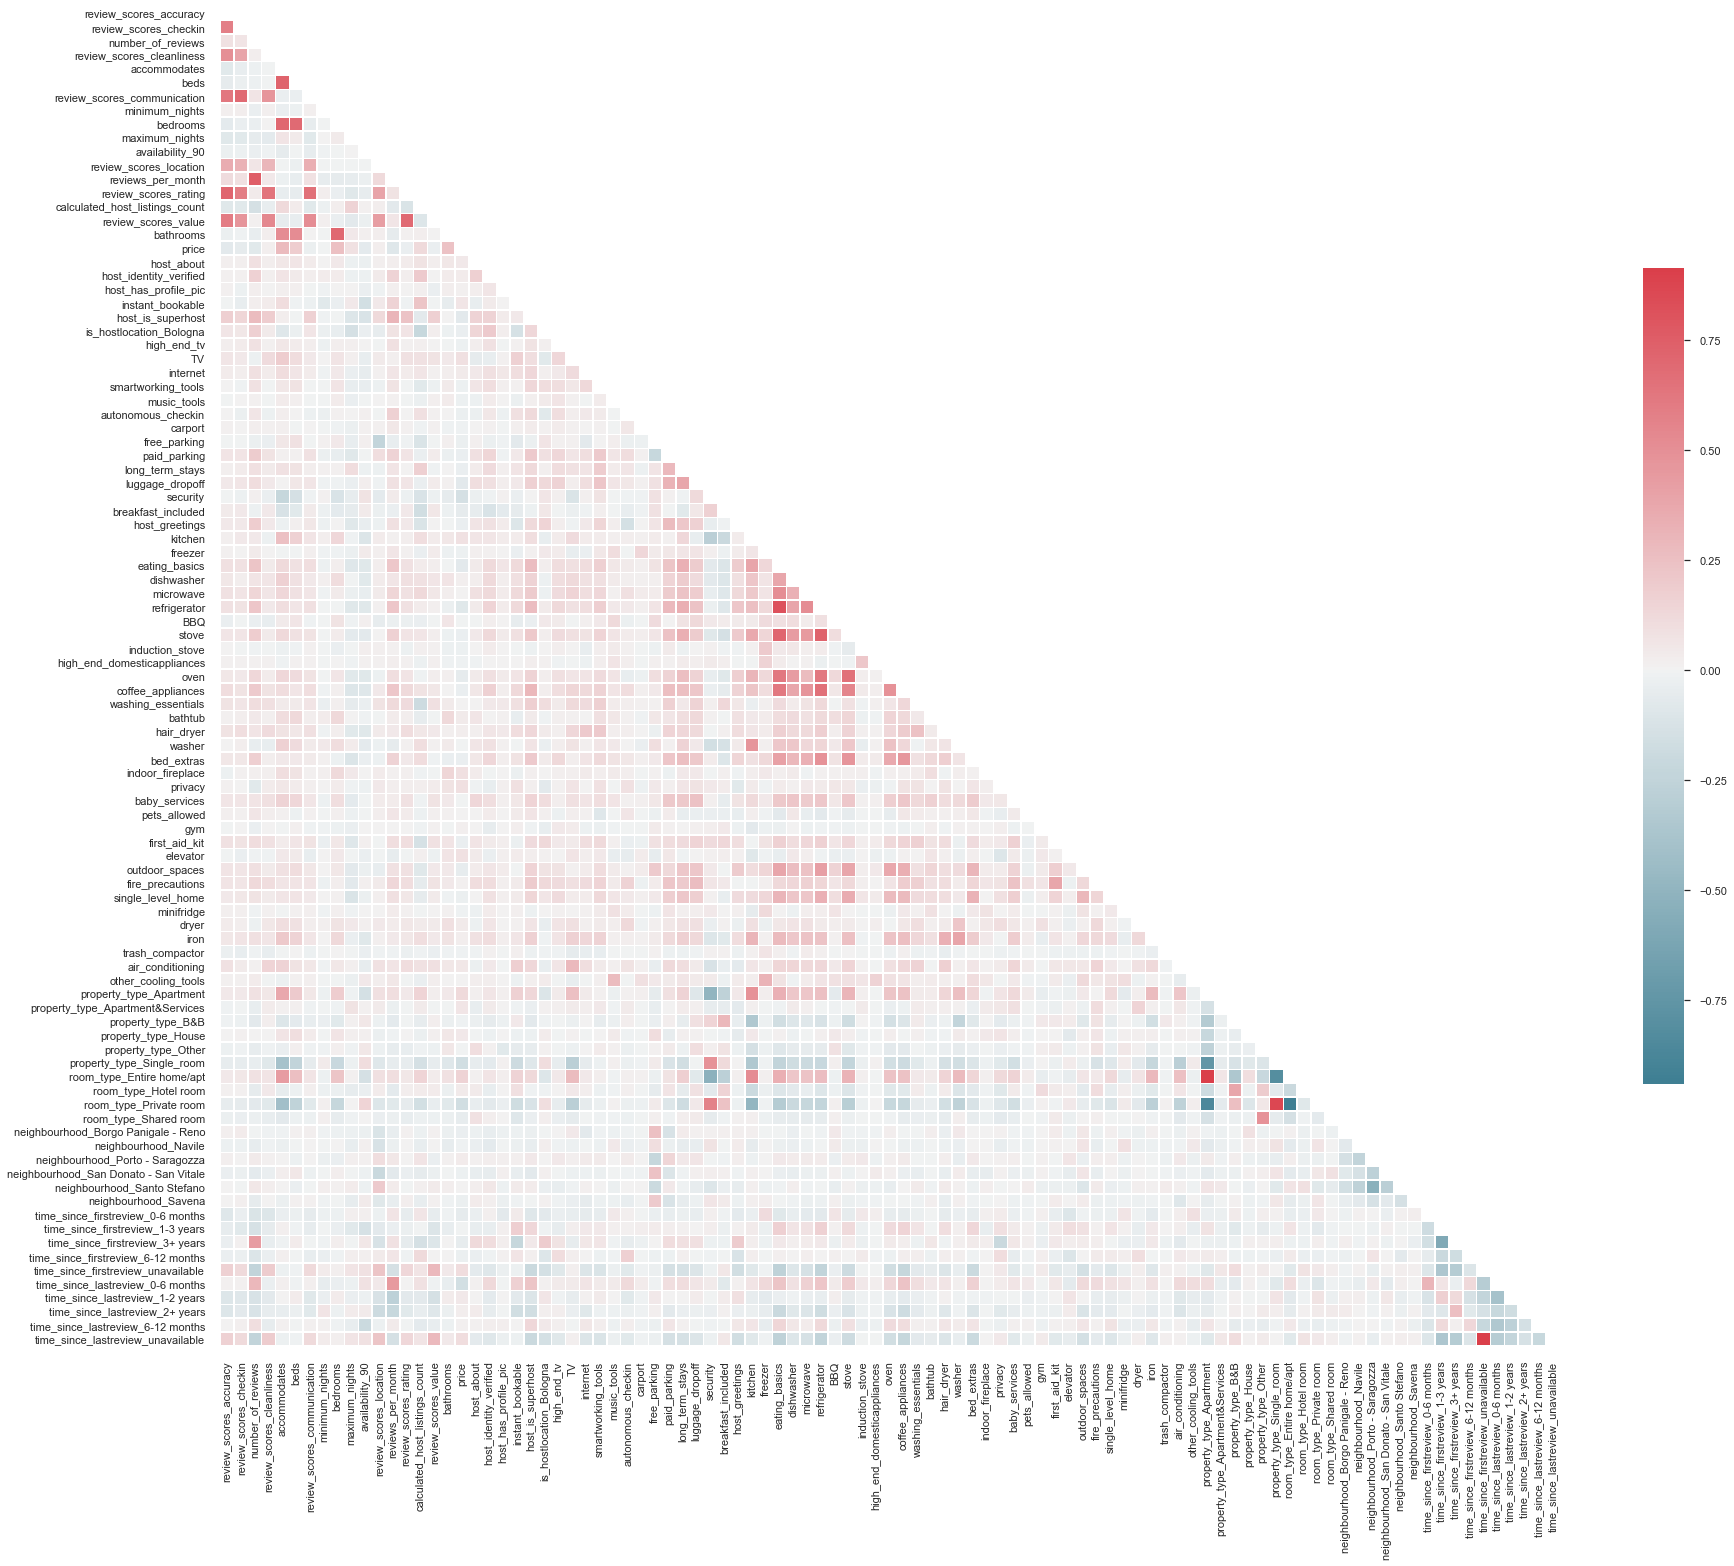

In [145]:
multi_collinearity_heatmap(df_pred,figsize=(30,30))

Area of high correlation are among reviews (unsurprinsingly, if one is satisfied with the property all aspects appeaar to be fine), domestic appliances vs eating basics and different types of property and room type. 

As expected there is high correlation between:
- beds and accomodates (clearly the more people the property accomodates, the more bedrooms, beds etc) -> I'll remove accomodates to reduce collinearity
- n° of reviews and reviews per month (sum of the other)-> I'll keep n° of reviews because this is the number that a potential customer will see on the platform 
- eating_basics e gli actual basics (quindi stove, microwave, etc) -> tolgo eating_basics perchè ho unaa feature per ogni basic item più o meno

Other that are correlated but can be left: 
- private room e single room same meaning of the level but for two different features so I'll leave both
- review_score_communication e review_score_checkin perchè probabilmente parlandosi di più il checkin è stato più chiaro (se il checkin non è stato facile da fare imputano la causa alla poca comunicazione)

In [179]:
to_drop = ['accommodates',
          'reviews_per_month',
          'eating_basics']
df_pred.drop(to_drop, axis=1, inplace=True)

In [169]:
# no need to scale the features because RF is not affected by monotonic transformations of the data

In [180]:
#SPLIT THE DATASET
X = df_pred.drop('price', axis=1) #predictors 
Y = np.log(df_pred['price'])      #target variable (log transformed because left skewed)
                                                   #alternatively we could select just a subset of the df 
                                                   #SAPPIMI DIRE COSA NE PENSI DI QUEST'OPZIONE

# Create train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=223)
#https://scikit-learn.org/0.19/modules/generated/sklearn.cross_validation.train_test_split.html
#considering the great number of listings available 20% of the data assigned to the test set seems reasonable

In [181]:
#CREATE BASE MODEL
#fit the random forest
rf_model = RandomForestRegressor(max_depth=10, n_estimators = 50, random_state=223)
rf_model.fit(X_train, Y_train)

ppred = rf_model.predict(X_test)

forest_mse = mean_squared_error(Y_test, ppred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse 

#baseline da migliorare con hyperparameter tuning è 130 


0.505825029924617

C:\Users\isada\Anaconda3\envs\geo_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Residuals for the model')

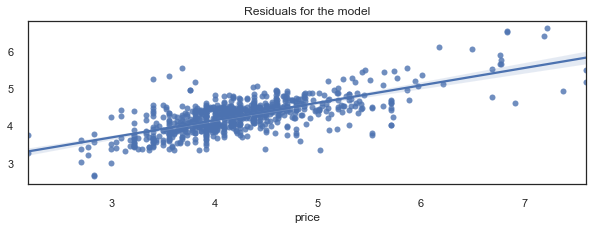

In [182]:
fig = plt.figure(figsize=(10,3))

sns.regplot((Y_test),(ppred))
plt.title("Residuals for the model")

probabilmente qui sta overfitting

In [183]:
#HYPERPARAMETER TUNING 
#I leverage GridSearchCV to get the paraameters grid used to select the best n° of trees
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

rf_model = RandomForestRegressor(random_state=223)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(rf_model, param_grid, cv=5,scoring='neg_mean_squared_error', return_train_score=True)

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#basically tells you best hyperparameter combination
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=223),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [184]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [185]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=223)

In [189]:
#FINAL MODEL TRAINING AND EVALUATION
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

193.99126339086024

In [188]:
confidence = 0.95
squared_errors = (final_predictions - Y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([0.4704605 , 0.56938926])

C:\Users\isada\Anaconda3\envs\geo_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Residuals for the model')

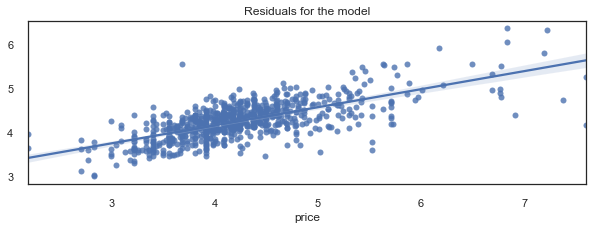

In [190]:
fig = plt.figure(figsize=(10,3))

sns.regplot((Y_test),(final_predictions))
plt.title("Residuals for the model")

## Which features affect the price (feature importance) 
Tree-based estimators can be used to compute feature importance. the importance of a feature is computed as the (normalized) total reduction of entropy brouhgt by that feature 

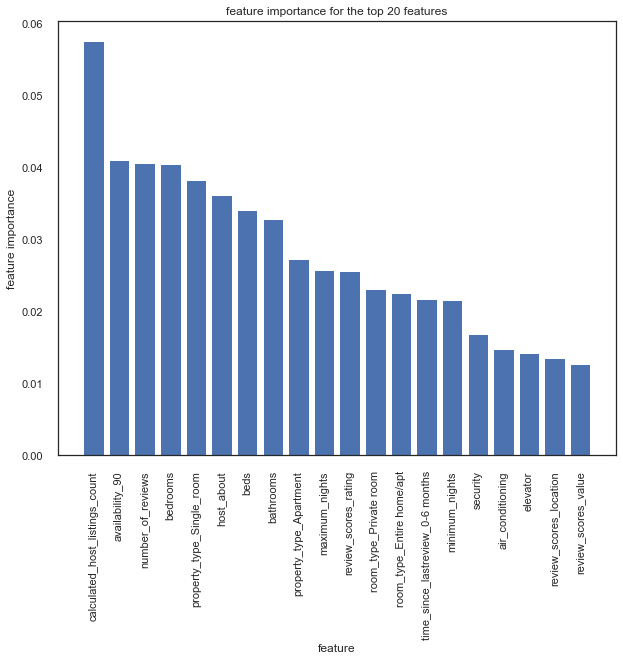

In [193]:
feature_importances = grid_search.best_estimator_.feature_importances_
attributes = X.columns
features = sorted(zip(feature_importances, attributes), reverse=True)

#Create list of all attributes and their coefficient for plotting purposes
attribute = []
coefficient = []
for feature in features:
    attribute.append(feature[1]) 
    coefficient.append(feature[0])
    
plt.figure(figsize=(10,8))
plt.bar(attribute[:20], height=coefficient[:20])
plt.xticks(rotation=90)
plt.xlabel('feature')
plt.ylabel('feature importance')
plt.title('feature importance for the top 20 features')
plt.show()

Queste rappresentano le 20 features che più impattano sul prezzo quindi abbiamo il setup (cioè se ha tutto quello che cerco), quanti listings l'host ha su Airbnb, quante reviews (fair enough), laa disponibilità nei prossimi 90 gg (quindi ragionevolmente non prenotano tanto prima di 90 gg) e così via

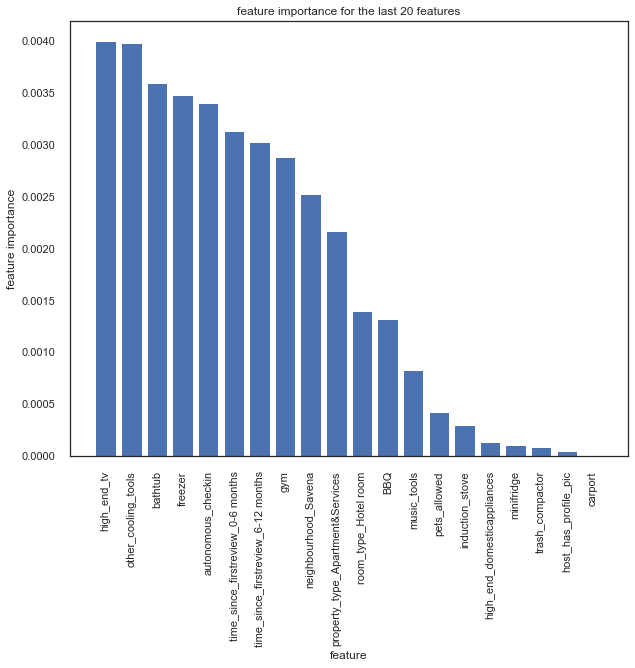

In [194]:
plt.figure(figsize=(10,8))
plt.bar(attribute[-20:], height=coefficient[-20:])
plt.xticks(rotation=90)
plt.xlabel('feature')
plt.ylabel('feature importance')
plt.title('feature importance for the last 20 features')
plt.show()

Queste sono invece le features che impaattano meno sul prezzo, vediamo come queste ultime impattano tutte più o meno nello stesso modo (anche se con andamento decrescente) tranne hotel_room e host_has_profile_pic

## Which amenities ?
To answer this take the median price of listings with and without the amenity (and count them to assess popularity) and see for which amenities the price increases aand for which is less than the median

In [123]:
df = pd.read_csv('data/clean_notencoded.csv') #ha tutte le colonne con le amenities boolean

In [131]:
def binary_count_and_price_plot_amenities(df, col, figsize=(8,3)):
    """
    counts the number of occurrence of T/F in the specified col of the df and plots a bar chart  
    for each of the two categories records the median price associated and plots the barchart
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col , fontsize=18, y=1)
    plt.subplots_adjust(top=0.70) 
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (€)')
    ax2.set_xlabel('')
    
    sns.despine()
    
    plt.show()

In [107]:
lst_amen = ['high_end_tv','TV','internet','smartworking_tools','music_tools',
            
            'autonomous_checkin','carport','free_parking','paid_parking','long_term_stays','luggage_dropoff',
            'security','breakfast_included','host_greetings',

            'kitchen','freezer','eating_basics','dishwasher','microwave','refrigerator','BBQ','stove',
            'induction_stove','high_end_domesticappliances','oven','coffee_appliances',

            'washing_essentials','bathtub','hair_dryer','washer',

            'bed_extras',

            'indoor_fireplace','privacy','baby_services','pets_allowed','gym','first_aid_kit',
            'elevator','outdoor_spaces','fire_precautions','single_level_home',
            'minifridge','dryer','iron','trash_compactor','air_conditioning','other_cooling_tools']

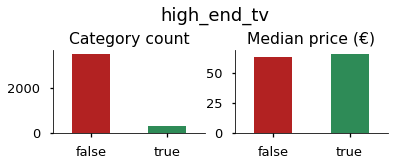

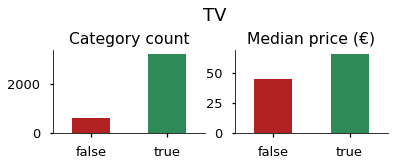

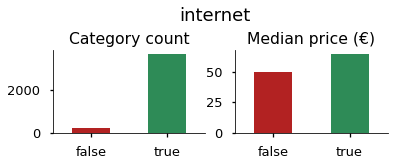

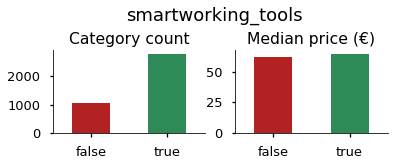

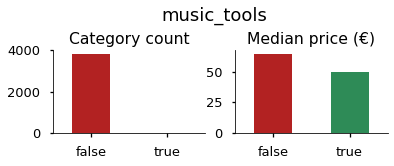

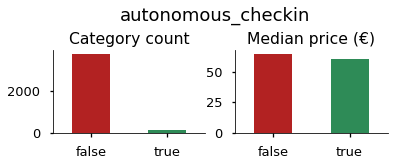

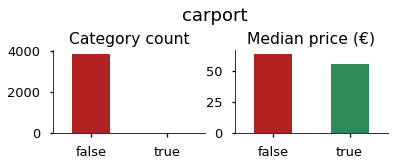

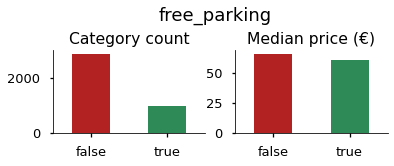

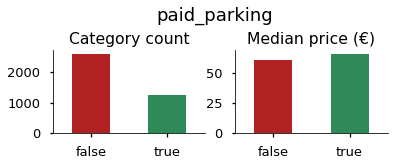

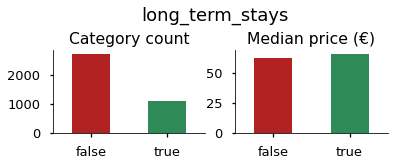

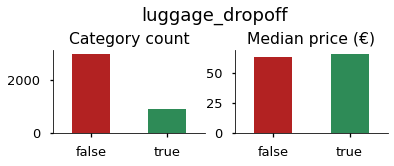

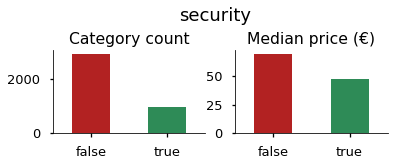

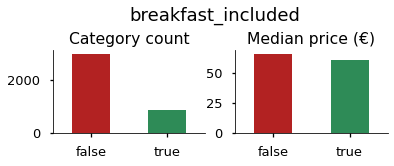

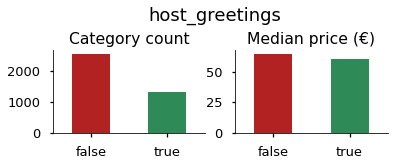

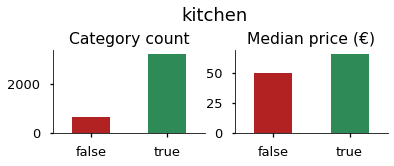

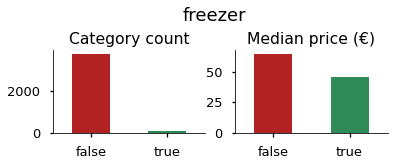

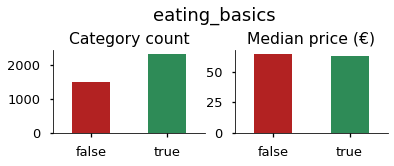

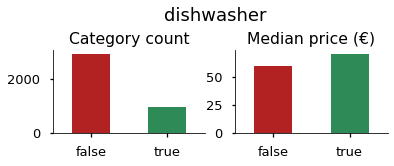

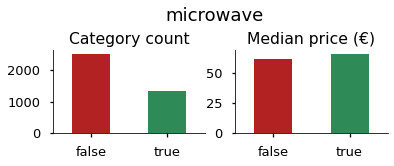

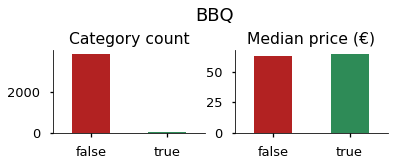

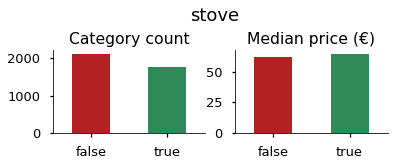

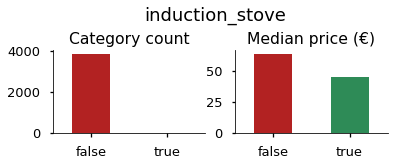

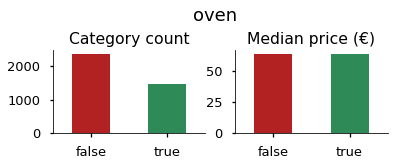

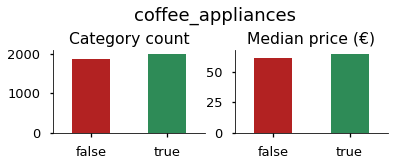

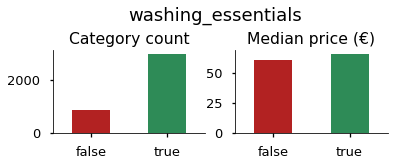

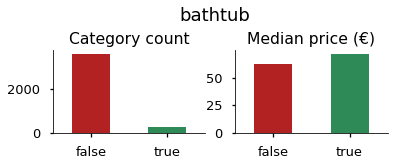

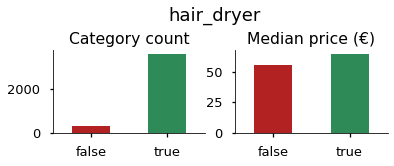

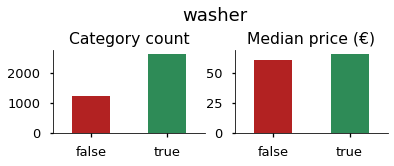

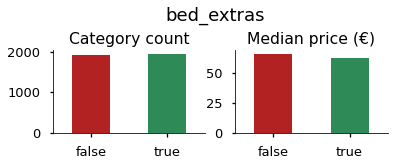

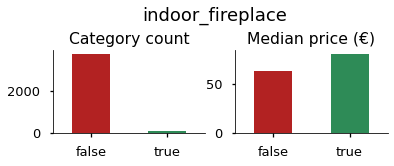

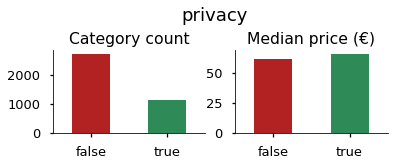

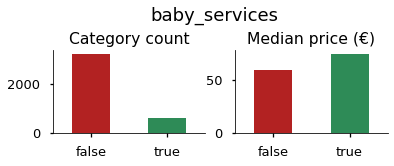

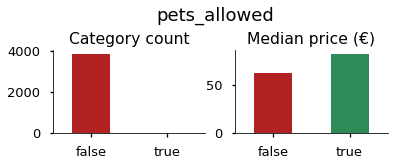

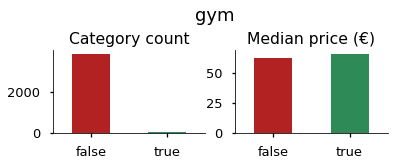

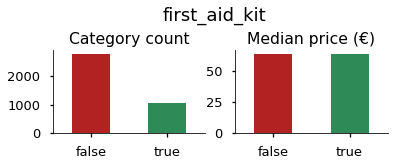

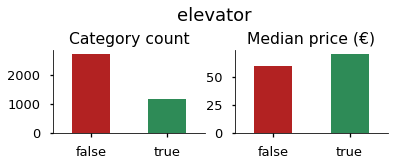

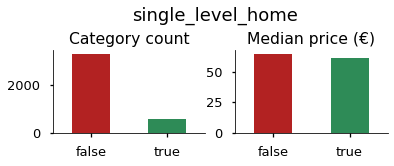

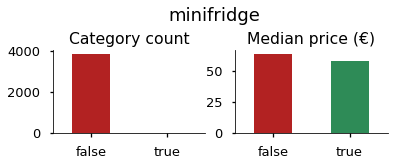

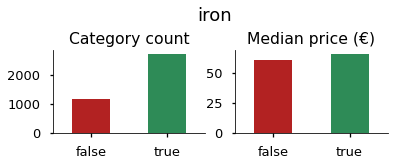

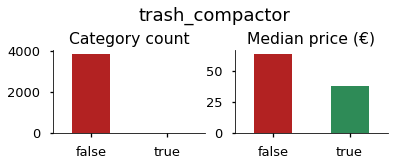

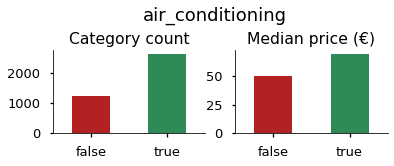

In [132]:
for col in lst_amen:
    binary_count_and_price_plot_amenities(df, col, figsize=(6,2))

In [134]:
#ci sono dei listings con music_toools ma sono molto pochi 

#DOBBIAMO DISCUTERE SE VOGLIAMO LEVARE LE AMENITIES CHE APPAIONO PER MENO DEL 5% DI LISTINGS (tipo music_tools,caarport, etc)

Quindi direi che bottom line è:
Nessun amenity fa variare il prezzo incredibilmente (location e setup sembrano essere i fattori principali) because regardless having them or not the price is always more or less the same value. However, le amenities (tra quelle più frequenti nell'offerta - perchè ricorda che nel cleaning ho tolto quelle che apparivano in meno del 10% dei listings) si possono dividere in 3 categorie:
1. BASICS: non averle significa dover richiedere un prezzo più basso (benchmark più o meno la mediana) - sono TV, Internet, air conditioning e kitchen
2. COMMON BUT INCREASING PRICE: smartworking tools, washer, iron e hairdryer 
3. UNCOMMON (the increase in price can be slight or relatively more significant but by virtue of being rare is still an amenity that you might be interested to have, if any just to differentiate the listing): offering baby services, long term stays, microwave, dishwasher, dryer, privacy, luggage dropoff, paid parking 

Note: ricorda che la mediana del nightly price è 63

Così secondo me dice più chiaramente se data l'offerta corrente introdurre una certa amenity nel tuo listing ti permette di aumentare il prezzo (però è meno formale della feature importance dele modello di predizione - anche se lì ti dice quali impattano di più ma non come impattano)

## Is it worth being superhost? Is it worth being verified
To assess this we can compare the median price charged when being a superhost vs normal hos and the same with verified hosts vs not verified hosts. If the median price is higher for superhost/verified then we can conclude that there is enough evidence to support becoming a superhost/verified host

In [97]:
def check_superhost_verified(df, col, figsize=(8,3)):
    """
    counts the number of occurrence of T/F in the specified col of the df and plots a bar chart  
    for each of the two categories records the median price associated and plots the barchart
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Is it worth to be '+col[-9:].replace('_','')+'?', fontsize=20, y=1)
    plt.subplots_adjust(top=0.65) 
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count \n')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (€) \n')
    ax2.set_xlabel('')
    
    sns.despine()
    
    plt.show()

In [ ]:
binary_count_and_price_plot(df,'host_is_superhost')

The non superhosts are about twice the number of the superhosts so there are not many superhosts but the price charged by superhosts seems to not be that much higher (though this doesn't tell anything about the frequency of the booking because maybe being superhost makes you more trustworthy and so price being equal you can obtain more bookings so eventually more profit - with data about the actual bookings one could check better if it's worth it - or could define some measure that merges the price and the review but in the interest of time this will work)

In [ ]:
binary_count_and_price_plot(df,'host_identity_verified')

The price for verified is slightly higher than non verified, though it seems to be like a standard so it's more about charging less if not verified 

Note:

Verified host = one whose online identity is consistent with the offline identification (personal ID verified)

Superhost = particular status of excellence among hosts 